<a href="https://colab.research.google.com/github/KHAWLIWEN/FYP/blob/main/Copy_of_FYP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount my Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change to the directory where my image files are located and print the list of folders
import os
os.chdir('/content/drive/MyDrive/colab/OASIS')
print(os.listdir('.'))

['train', 'test', 'RESULT', 'vgg16D2_train_vs_val_loss.png', 'vgg16D2_train_vs_val_acc.png', 'vgg16D2_true_vs_predict.png', 'vgg16D2_val set confusion matrix.png', 'FYP2_vgg16D2.h5', 'vgg16D3_train_vs_val_loss.png', 'vgg16D3_train_vs_val_acc.png', 'vgg16D3_true_vs_predict.png', 'vgg16D3_val set confusion matrix.png', 'FYP2_vgg16D3.h5', 'vgg16D5_train_vs_val_loss.png', 'vgg16D5_train_vs_val_acc.png', 'vgg16D5_true_vs_predict.png', 'vgg16D5_val set confusion matrix.png', 'FYP2_vgg16D5.h5', 'vgg16FFC1_train_vs_val_loss.png', 'vgg16FFC1_train_vs_val_acc.png', 'vgg16FFC1_true_vs_predict.png', 'vgg16FFC1_val set confusion matrix.png', 'FYP2_vgg16FFC1.h5', 'vgg16FFC1D5_train_vs_val_loss.png', 'vgg16FFC1D5_train_vs_val_acc.png', 'vgg16FFC1D5_true_vs_predict.png', 'vgg16FFC1D5_val set confusion matrix.png', 'FYP2_vgg16FFC1D5.h5']


In [ ]:
# import libraries
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image

from keras.utils import plot_model

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input,BatchNormalization,GlobalAveragePooling2D, Activation

from sklearn.metrics import confusion_matrix, classification_report

# **LOAD DATA**

In [ ]:
base_dir="/content/drive/My Drive/colab/OASIS/"

In [ ]:
train=base_dir+ 'train/'

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train,
    validation_split=0.2,
    image_size=(224,224),
    batch_size= 16,
    subset='training',
    seed=1000 )

Found 2768 files belonging to 3 classes.
Using 2215 files for training.


In [ ]:
val=base_dir+ 'train/'

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    image_size=(224,224),
    batch_size=16,
    subset='validation',
    seed=1000
    )

Found 2768 files belonging to 3 classes.
Using 553 files for validation.


In [ ]:
test=base_dir +'test/'

test_data=tf.keras.preprocessing.image_dataset_from_directory(
    test,
    image_size=(224,224),
    batch_size=16,
    seed=1000
    )

Found 169 files belonging to 3 classes.


In [ ]:
class_names = ['AD', 'MCI', 'NC']

In [ ]:
train_data.class_names = class_names
val_data.class_names = class_names

In [ ]:
print(val_data)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# **DATA AUGMENTATION**

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2)
])


In [ ]:
# Data augmentation result
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# **MobilenetV2**

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Model Initialization
base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False


9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Define the model architecture
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D(name="GloPool")(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(10e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
import time
# get the start time
st=time.time()

initial_epochs = 50
mobilenetV2_history=model.fit (train_data,
                    validation_data=val_data,
                    epochs= initial_epochs,
                   verbose=1
                  )

# get the end time
et= time.time()

# get the execution time
res = et - st
final_res = res/60
print('Execution time:', final_res , 'minutes')

Epoch 1/50
139/139 [==============================] - 551s 4s/step - loss: 1.0495 - accuracy: 0.4587 - val_loss: 1.0511 - val_accuracy: 0.5099
Epoch 2/50
139/139 [==============================] - 8s 57ms/step - loss: 0.9284 - accuracy: 0.5517 - val_loss: 0.8974 - val_accuracy: 0.5841
Epoch 3/50
139/139 [==============================] - 7s 49ms/step - loss: 0.8836 - accuracy: 0.5842 - val_loss: 0.8607 - val_accuracy: 0.6004
Epoch 4/50
139/139 [==============================] - 7s 50ms/step - loss: 0.8531 - accuracy: 0.6023 - val_loss: 0.8717 - val_accuracy: 0.6094
Epoch 5/50
139/139 [==============================] - 8s 59ms/step - loss: 0.8307 - accuracy: 0.6041 - val_loss: 0.8398 - val_accuracy: 0.6076
Epoch 6/50
139/139 [==============================] - 8s 58ms/step - loss: 0.8215 - accuracy: 0.6230 - val_loss: 0.8187 - val_accuracy: 0.6401
Epoch 7/50
139/139 [==============================] - 7s 49ms/step - loss: 0.7906 - accuracy: 0.6384 - val_loss: 0.8540 - val_accuracy: 0.6184

In [ ]:
model.evaluate(train_data)

139/139 [==============================] - 7s 47ms/step - loss: 0.5459 - accuracy: 0.7657


[0.5458803772926331, 0.7656884789466858]

In [ ]:
model.evaluate(val_data)

35/35 [==============================] - 1s 33ms/step - loss: 0.6936 - accuracy: 0.6908


[0.6935986876487732, 0.690777599811554]

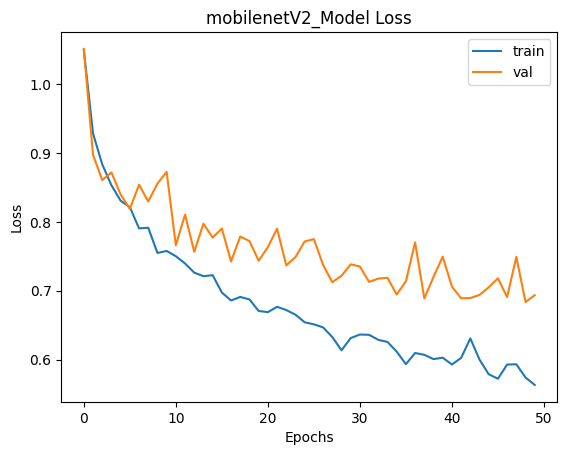

In [ ]:
loss = mobilenetV2_history.history['loss']
val_loss = mobilenetV2_history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('mobilenetV2_Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("mobilenetV2_train_vs_val_loss.png")
plt.show()

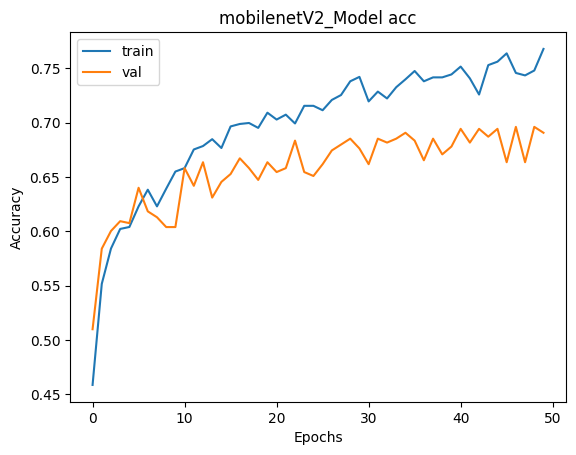

In [ ]:
accuracy = mobilenetV2_history.history['accuracy']
val_accuracy = mobilenetV2_history.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('mobilenetV2_Model acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("mobilenetV2_train_vs_val_acc.png")
plt.show()

In [ ]:
class_names={0:"AD", 1:"MCI", 2:"NC"}

1/1 [==============================] - 0s 22ms/step


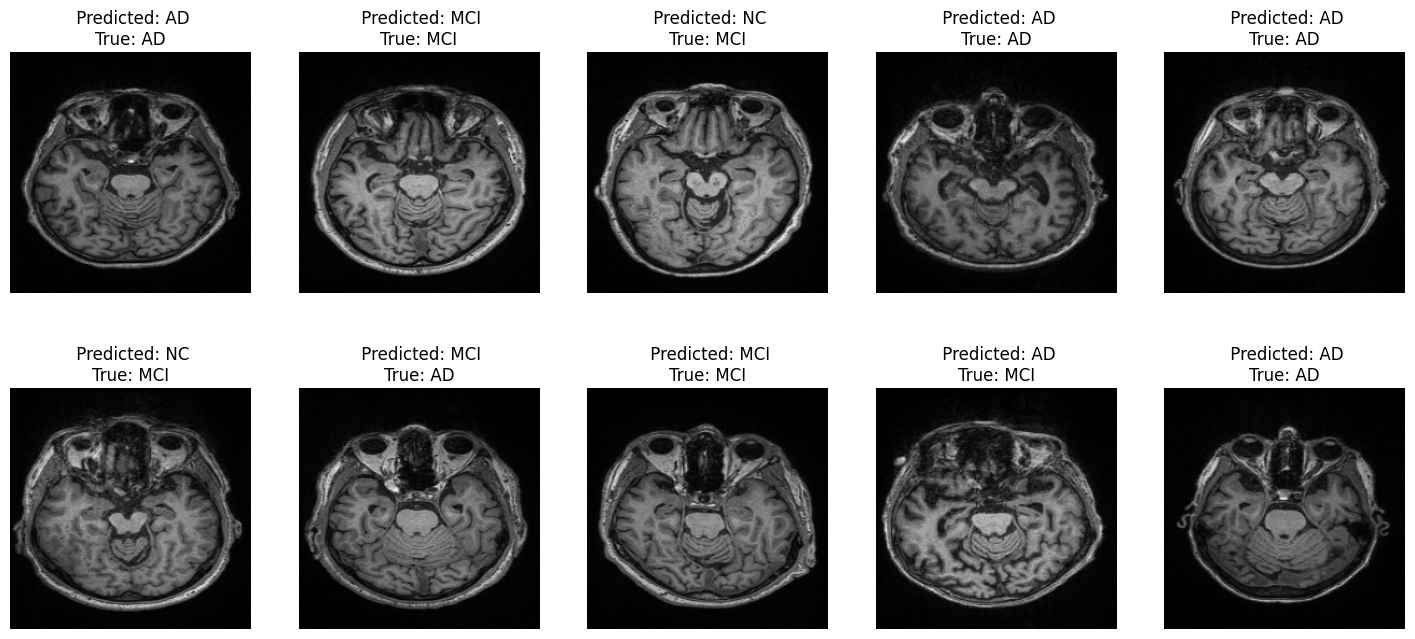

In [ ]:
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(18,8))
for images, labels in val_data.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i]/255)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        x = image.img_to_array(images[i])
        x = np.expand_dims(x, axis=0)
        p=np.argmax(model.predict(x))
        plt.title(f" Predicted: {class_names[p]}\nTrue: {val_data.class_names[labels[i]]}")
        plt.axis('off')
plt.savefig("mobilenetV2_true_vs_predict.png")

In [ ]:
import itertools
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Predicted')

Found 2768 files belonging to 3 classes.
Using 553 files for validation.
1/1 [==============================] - 0s 36ms/step


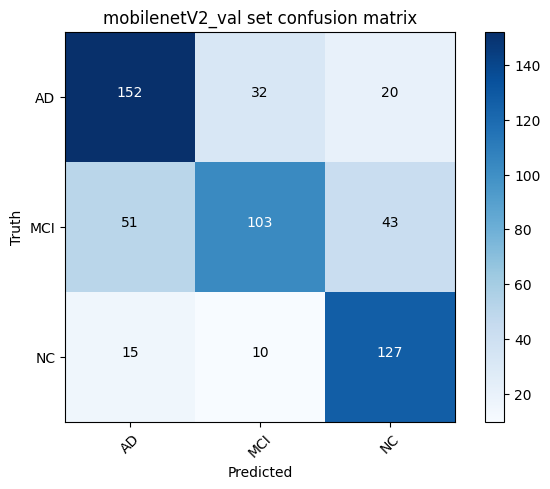

In [ ]:
val=base_dir+ 'train/'

mobilenetV2_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
    )
v_predictions = np.array([])
v_labels =  np.array([])
for x, y in mobilenetV2_val_data:
    v_predictions = np.concatenate([v_predictions, np.argmax(model.predict(x), axis = -1)])
    v_labels = np.concatenate([v_labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=v_labels, predictions=v_predictions).numpy()
confusion_mtx = confusion_matrix(v_labels, v_predictions)

plot_confusion_matrix(confusion_mtx, classes =  ['AD', 'MCI', 'NC'], title = 'mobilenetV2_val set confusion matrix')
plt.savefig("mobilenetV2_val set confusion matrix.png")

In [ ]:
report = classification_report(v_labels, v_predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.70      0.75      0.72       204
         1.0       0.71      0.52      0.60       197
         2.0       0.67      0.84      0.74       152

    accuracy                           0.69       553
   macro avg       0.69      0.70      0.69       553
weighted avg       0.69      0.69      0.68       553



In [ ]:
model.save("./FYP2_mobilenetV2.h5")

# **InceptionV3**

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Model Initialization
base_model = InceptionV3(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False


87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
# Define the model architecture
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D(name="GloPool")(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 GloPool (GlobalAveragePooli  (None, 2048)             0   

In [ ]:
len(model.trainable_variables)

2

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(10e-4),
                          loss="sparse_categorical_crossentropy",
                          metrics=["accuracy"])


In [ ]:
import time
# get the start time
st=time.time()

initial_epochs = 50
inceptionV3_history=model.fit (train_data,
                    validation_data=val_data,
                    epochs= initial_epochs,
                   verbose=1
                  )

# get the end time
et= time.time()

# get the execution time
res = et - st
final_res = res/60
print('Execution time:', final_res , 'minutes')

Epoch 1/50
139/139 [==============================] - 20s 101ms/step - loss: 1.1084 - accuracy: 0.4271 - val_loss: 0.9617 - val_accuracy: 0.5425
Epoch 2/50
139/139 [==============================] - 8s 55ms/step - loss: 0.9797 - accuracy: 0.5133 - val_loss: 1.1320 - val_accuracy: 0.4557
Epoch 3/50
139/139 [==============================] - 9s 66ms/step - loss: 0.9775 - accuracy: 0.5336 - val_loss: 0.9421 - val_accuracy: 0.5714
Epoch 4/50
139/139 [==============================] - 9s 60ms/step - loss: 0.9293 - accuracy: 0.5630 - val_loss: 0.9112 - val_accuracy: 0.5624
Epoch 5/50
139/139 [==============================] - 8s 55ms/step - loss: 0.8813 - accuracy: 0.5824 - val_loss: 0.9956 - val_accuracy: 0.5479
Epoch 6/50
139/139 [==============================] - 9s 65ms/step - loss: 0.8615 - accuracy: 0.5995 - val_loss: 0.8340 - val_accuracy: 0.6130
Epoch 7/50
139/139 [==============================] - 9s 61ms/step - loss: 0.8441 - accuracy: 0.6122 - val_loss: 0.8446 - val_accuracy: 0.60

In [ ]:
model.evaluate(train_data)

139/139 [==============================] - 7s 48ms/step - loss: 0.6733 - accuracy: 0.6971


[0.6733328700065613, 0.6970654726028442]

In [ ]:
model.evaluate(val_data)

35/35 [==============================] - 3s 60ms/step - loss: 0.7708 - accuracy: 0.6618


[0.7708475589752197, 0.6618444919586182]

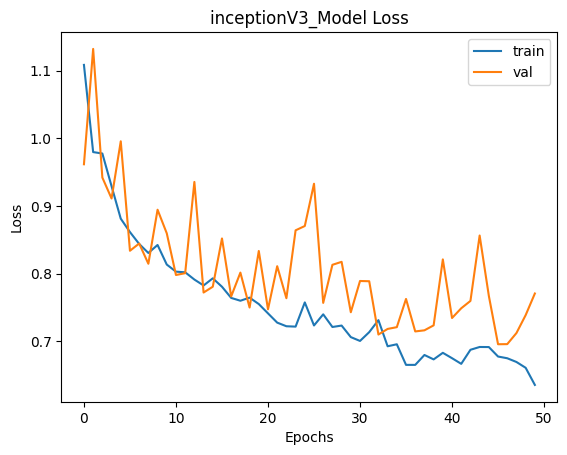

In [ ]:
loss = inceptionV3_history.history['loss']
val_loss = inceptionV3_history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('inceptionV3_Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("inceptionV3_train_vs_val_loss.png")
plt.show()

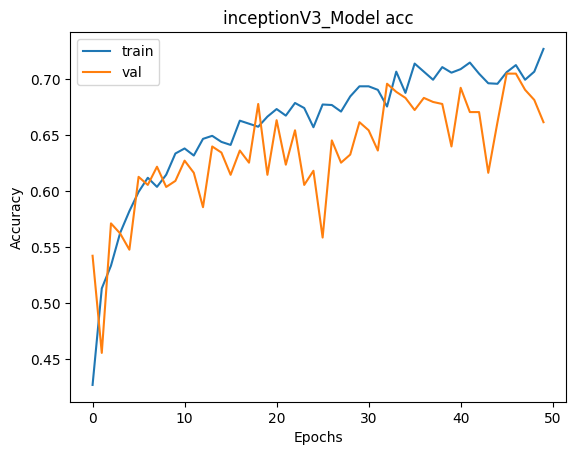

In [ ]:
accuracy = inceptionV3_history.history['accuracy']
val_accuracy = inceptionV3_history.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('inceptionV3_Model acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("inceptionV3_train_vs_val_acc.png")
plt.show()

In [ ]:
class_names={0:"AD", 1:"MCI", 2:"NC"}

1/1 [==============================] - 0s 26ms/step


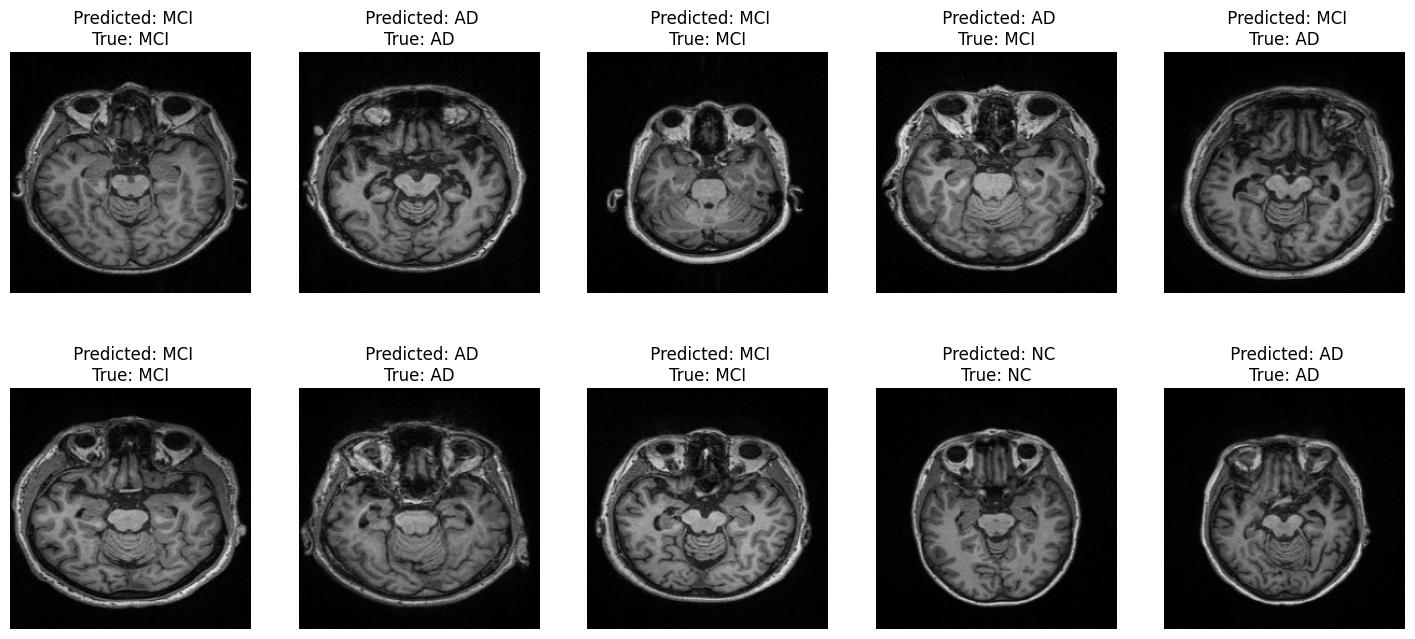

In [ ]:
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(18,8))
for images, labels in val_data.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i]/255)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        x = image.img_to_array(images[i])
        x = np.expand_dims(x, axis=0)
        p=np.argmax(model.predict(x))
        plt.title(f" Predicted: {class_names[p]}\nTrue: {val_data.class_names[labels[i]]}")
        plt.axis('off')
plt.savefig("inceptionV3_true_vs_predict.png")

In [ ]:
import itertools
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Predicted')

Found 2768 files belonging to 3 classes.
Using 553 files for validation.
1/1 [==============================] - 0s 28ms/step


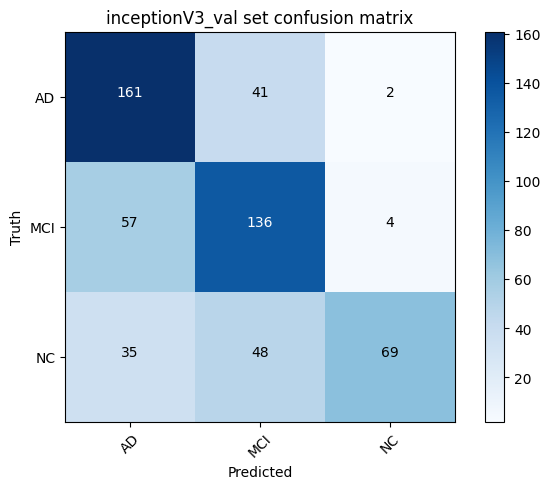

In [ ]:
val=base_dir+ 'train/'

inceptionV3_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
    )
v_predictions = np.array([])
v_labels =  np.array([])
for x, y in inceptionV3_val_data:
    v_predictions = np.concatenate([v_predictions, np.argmax(model.predict(x), axis = -1)])
    v_labels = np.concatenate([v_labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=v_labels, predictions=v_predictions).numpy()
confusion_mtx = confusion_matrix(v_labels, v_predictions)

plot_confusion_matrix(confusion_mtx, classes =  ['AD', 'MCI', 'NC'], title = 'inceptionV3_val set confusion matrix')
plt.savefig("inceptionV3_val set confusion matrix.png")

In [ ]:
report = classification_report(v_labels, v_predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.64      0.79      0.70       204
         1.0       0.60      0.69      0.64       197
         2.0       0.92      0.45      0.61       152

    accuracy                           0.66       553
   macro avg       0.72      0.64      0.65       553
weighted avg       0.70      0.66      0.66       553



In [ ]:
model.save("./FYP2_inceptionV3.h5")

# **VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16

# Model Initialization
base_model = VGG16(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False


58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
# Define the model architecture
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D(name="GloPool")(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 GloPool (GlobalAveragePooli  (None, 512)              0         
 ng2D)                                                       

In [ ]:
len(model.trainable_variables)

2

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(10e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
import time
# get the start time
st=time.time()

initial_epochs = 50
vgg16_history=model.fit (train_data,
                    validation_data=val_data,
                    epochs= initial_epochs,
                   verbose=1
                  )

# get the end time
et= time.time()

# get the execution time
res = et - st
final_res = res/60
print('Execution time:', final_res , 'minutes')

Epoch 1/50
139/139 [==============================] - 19s 110ms/step - loss: 1.7870 - accuracy: 0.4036 - val_loss: 1.4434 - val_accuracy: 0.4376
Epoch 2/50
139/139 [==============================] - 12s 86ms/step - loss: 1.1781 - accuracy: 0.4889 - val_loss: 1.0628 - val_accuracy: 0.5136
Epoch 3/50
139/139 [==============================] - 12s 85ms/step - loss: 1.0433 - accuracy: 0.5467 - val_loss: 1.0512 - val_accuracy: 0.5280
Epoch 4/50
139/139 [==============================] - 12s 83ms/step - loss: 0.9416 - accuracy: 0.5833 - val_loss: 0.8941 - val_accuracy: 0.5913
Epoch 5/50
139/139 [==============================] - 13s 92ms/step - loss: 0.8657 - accuracy: 0.6149 - val_loss: 0.8967 - val_accuracy: 0.5931
Epoch 6/50
139/139 [==============================] - 12s 86ms/step - loss: 0.8223 - accuracy: 0.6330 - val_loss: 0.9489 - val_accuracy: 0.5895
Epoch 7/50
139/139 [==============================] - 12s 85ms/step - loss: 0.7933 - accuracy: 0.6555 - val_loss: 0.8389 - val_accuracy

In [ ]:
model.evaluate(train_data)

139/139 [==============================] - 9s 64ms/step - loss: 0.5241 - accuracy: 0.7833


[0.524059534072876, 0.7832956910133362]

In [ ]:
model.evaluate(val_data)

35/35 [==============================] - 3s 65ms/step - loss: 0.7020 - accuracy: 0.7143


[0.701955258846283, 0.7142857313156128]

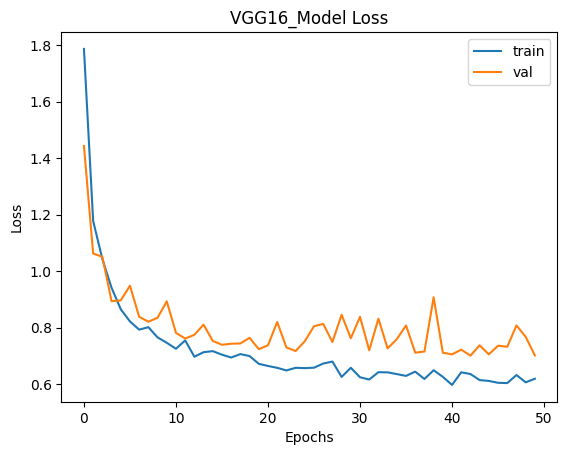

In [ ]:
loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('VGG16_Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16_train_vs_val_loss.png")
plt.show()

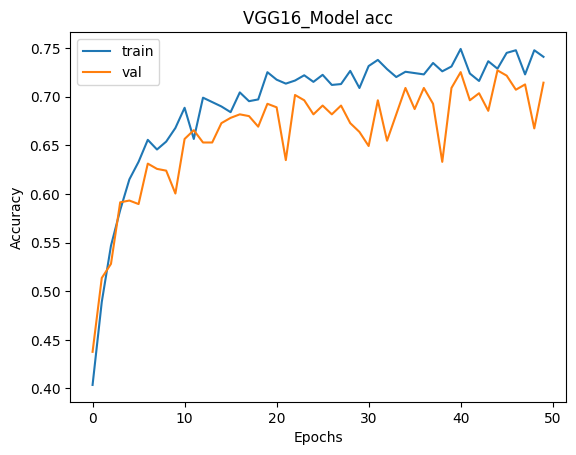

In [ ]:
accuracy = vgg16_history.history['accuracy']
val_accuracy = vgg16_history.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('VGG16_Model acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16_train_vs_val_acc.png")
plt.show()

In [ ]:
class_names={0:"AD", 1:"MCI", 2:"NC"}

1/1 [==============================] - 0s 20ms/step


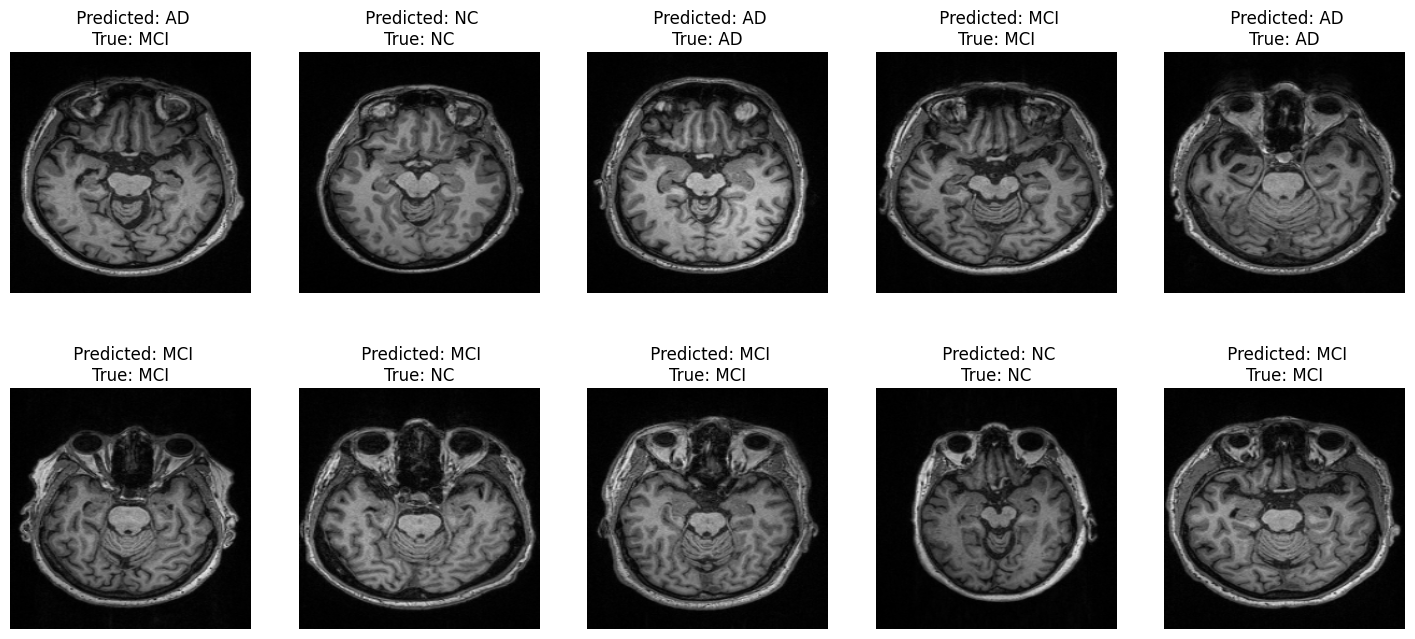

In [ ]:
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(18,8))
for images, labels in val_data.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i]/255)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        x = image.img_to_array(images[i])
        x = np.expand_dims(x, axis=0)
        p=np.argmax(model.predict(x))
        plt.title(f" Predicted: {class_names[p]}\nTrue: {val_data.class_names[labels[i]]}")
        plt.axis('off')
plt.savefig("vgg16_true_vs_predict.png")

In [ ]:
import itertools
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Predicted')

Found 2768 files belonging to 3 classes.
Using 553 files for validation.
1/1 [==============================] - 0s 32ms/step


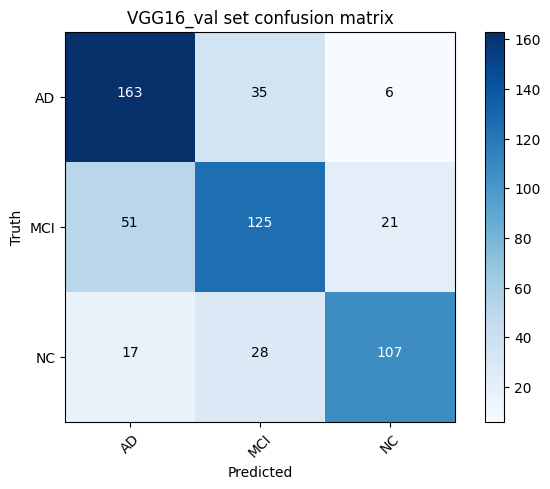

In [ ]:
val=base_dir+ 'train/'

vgg16_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=16,
    subset='validation',
    seed=1000
    )
v_predictions = np.array([])
v_labels =  np.array([])
for x, y in vgg16_val_data:
    v_predictions = np.concatenate([v_predictions, np.argmax(model.predict(x), axis = -1)])
    v_labels = np.concatenate([v_labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=v_labels, predictions=v_predictions).numpy()
confusion_mtx = confusion_matrix(v_labels, v_predictions)

plot_confusion_matrix(confusion_mtx, classes =  ['AD', 'MCI', 'NC'], title = 'VGG16_val set confusion matrix')
plt.savefig("vgg16_val set confusion matrix.png")

In [ ]:
report = classification_report(v_labels, v_predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.71      0.80      0.75       204
         1.0       0.66      0.63      0.65       197
         2.0       0.80      0.70      0.75       152

    accuracy                           0.71       553
   macro avg       0.72      0.71      0.72       553
weighted avg       0.72      0.71      0.71       553



In [ ]:
model.save("./FYP2_vgg16.h5")

# **VGG16+1FC**

In [ ]:
from tensorflow.keras.applications import VGG16

# Model Initialization
base_model = VGG16(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False


In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
# Define the model architecture
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = layers.Flatten(name="flatten")(x)
x = layers.Dense (256, activation = 'relu')(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0   

In [ ]:
len(model.trainable_variables)

4

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(10e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
import time
# get the start time
st=time.time()

initial_epochs = 50
vgg16FFC1_history=model.fit (train_data,
                    validation_data=val_data,
                    epochs= initial_epochs,
                   verbose=1
                  )

# get the end time
et= time.time()

# get the execution time
res = et - st
final_res = res/60
print('Execution time:', final_res , 'minutes')

Epoch 1/50
139/139 [==============================] - 18s 109ms/step - loss: 7.7418 - accuracy: 0.5210 - val_loss: 2.4956 - val_accuracy: 0.4937
Epoch 2/50
139/139 [==============================] - 14s 99ms/step - loss: 1.0174 - accuracy: 0.6628 - val_loss: 0.6192 - val_accuracy: 0.7378
Epoch 3/50
139/139 [==============================] - 13s 92ms/step - loss: 0.6307 - accuracy: 0.7431 - val_loss: 0.5956 - val_accuracy: 0.7722
Epoch 4/50
139/139 [==============================] - 13s 92ms/step - loss: 0.4893 - accuracy: 0.8032 - val_loss: 0.4650 - val_accuracy: 0.8047
Epoch 5/50
139/139 [==============================] - 14s 94ms/step - loss: 0.4503 - accuracy: 0.8244 - val_loss: 0.5038 - val_accuracy: 0.8029
Epoch 6/50
139/139 [==============================] - 13s 94ms/step - loss: 0.4090 - accuracy: 0.8388 - val_loss: 0.4702 - val_accuracy: 0.8029
Epoch 7/50
139/139 [==============================] - 13s 95ms/step - loss: 0.3747 - accuracy: 0.8582 - val_loss: 0.3739 - val_accuracy

In [ ]:
model.evaluate(train_data)

139/139 [==============================] - 10s 73ms/step - loss: 0.0506 - accuracy: 0.9801


[0.050635308027267456, 0.980135440826416]

In [ ]:
model.evaluate(val_data)

35/35 [==============================] - 3s 71ms/step - loss: 0.3252 - accuracy: 0.8861


[0.32515689730644226, 0.8860759735107422]

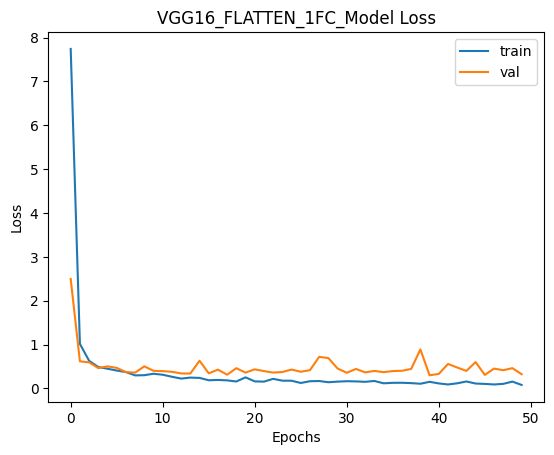

In [ ]:
loss = vgg16FFC1_history.history['loss']
val_loss = vgg16FFC1_history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('VGG16_FLATTEN_1FC_Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16FFC1_train_vs_val_loss.png")
plt.show()

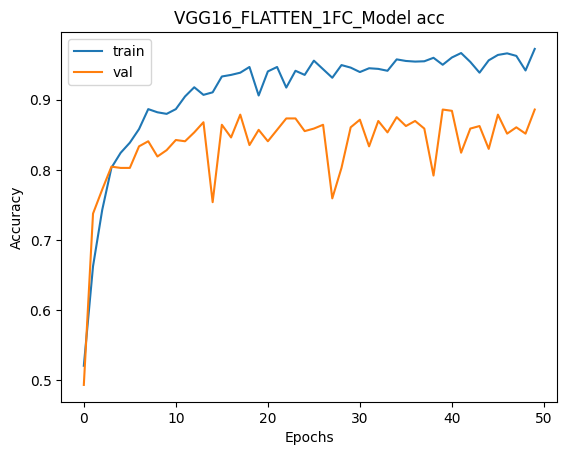

In [ ]:
accuracy = vgg16FFC1_history.history['accuracy']
val_accuracy = vgg16FFC1_history.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('VGG16_FLATTEN_1FC_Model acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16FFC1_train_vs_val_acc.png")
plt.show()

In [ ]:
class_names={0:"AD", 1:"MCI", 2:"NC"}

1/1 [==============================] - 0s 24ms/step


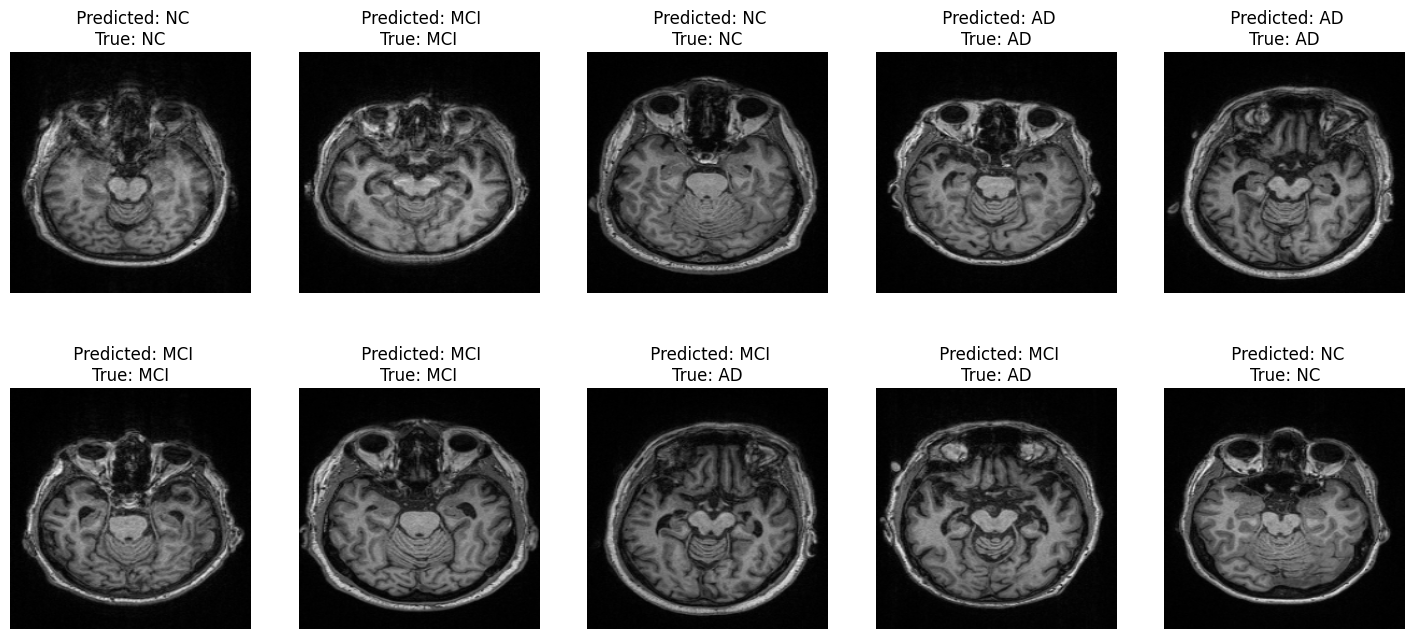

In [ ]:
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(18,8))
for images, labels in val_data.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i]/255)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        x = image.img_to_array(images[i])
        x = np.expand_dims(x, axis=0)
        p=np.argmax(model.predict(x))
        plt.title(f" Predicted: {class_names[p]}\nTrue: {val_data.class_names[labels[i]]}")
        plt.axis('off')
plt.savefig("vgg16FFC1_true_vs_predict.png")

In [ ]:
import itertools
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Predicted')

Found 2768 files belonging to 3 classes.
Using 553 files for validation.
1/1 [==============================] - 0s 25ms/step


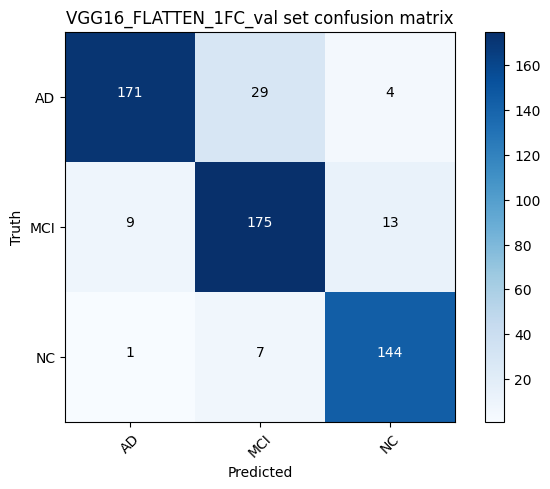

In [ ]:
val=base_dir+ 'train/'

vgg16FFC1_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
    )
v_predictions = np.array([])
v_labels =  np.array([])
for x, y in vgg16FFC1_val_data:
    v_predictions = np.concatenate([v_predictions, np.argmax(model.predict(x), axis = -1)])
    v_labels = np.concatenate([v_labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=v_labels, predictions=v_predictions).numpy()
confusion_mtx = confusion_matrix(v_labels, v_predictions)

plot_confusion_matrix(confusion_mtx, classes =  ['AD', 'MCI', 'NC'], title = 'VGG16_FLATTEN_1FC_val set confusion matrix')
plt.savefig("vgg16FFC1_val set confusion matrix.png")

In [ ]:
report = classification_report(v_labels, v_predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89       204
         1.0       0.83      0.89      0.86       197
         2.0       0.89      0.95      0.92       152

    accuracy                           0.89       553
   macro avg       0.89      0.89      0.89       553
weighted avg       0.89      0.89      0.89       553



In [ ]:
model.save("./FYP2_vgg16FFC1.h5")

# **VGG16+2FC**

In [ ]:
from tensorflow.keras.applications import VGG16

# Model Initialization
base_model = VGG16(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False


In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
# Define the model architecture
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D(name="GloPool")(x)
x = layers.Dense (256, activation = 'relu')(x)
x = layers.Dense (128, activation = 'relu')(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 GloPool (GlobalAveragePooli  (None, 512)              0   

In [ ]:
len(model.trainable_variables)

6

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(10e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
import time
# get the start time
st=time.time()

initial_epochs = 50
vgg16FC2_history=model.fit (train_data,
                    validation_data=val_data,
                    epochs= initial_epochs,
                   verbose=1
                  )

# get the end time
et= time.time()

# get the execution time
res = et - st
final_res = res/60
print('Execution time:', final_res , 'minutes')

Epoch 1/50
139/139 [==============================] - 15s 95ms/step - loss: 1.1043 - accuracy: 0.5020 - val_loss: 0.9291 - val_accuracy: 0.5552
Epoch 2/50
139/139 [==============================] - 12s 88ms/step - loss: 0.8649 - accuracy: 0.5932 - val_loss: 0.9046 - val_accuracy: 0.5714
Epoch 3/50
139/139 [==============================] - 12s 87ms/step - loss: 0.8002 - accuracy: 0.6492 - val_loss: 1.0271 - val_accuracy: 0.5280
Epoch 4/50
139/139 [==============================] - 12s 88ms/step - loss: 0.7747 - accuracy: 0.6497 - val_loss: 0.7584 - val_accuracy: 0.6564
Epoch 5/50
139/139 [==============================] - 13s 88ms/step - loss: 0.7250 - accuracy: 0.6831 - val_loss: 0.8466 - val_accuracy: 0.6221
Epoch 6/50
139/139 [==============================] - 13s 89ms/step - loss: 0.6585 - accuracy: 0.7093 - val_loss: 0.7237 - val_accuracy: 0.6962
Epoch 7/50
139/139 [==============================] - 15s 107ms/step - loss: 0.6286 - accuracy: 0.7309 - val_loss: 0.6686 - val_accuracy

In [ ]:
model.evaluate(train_data)

139/139 [==============================] - 10s 68ms/step - loss: 0.1377 - accuracy: 0.9508


[0.13773919641971588, 0.9507900476455688]

In [ ]:
model.evaluate(val_data)

35/35 [==============================] - 3s 68ms/step - loss: 0.6184 - accuracy: 0.8391


[0.6184180974960327, 0.8390596508979797]

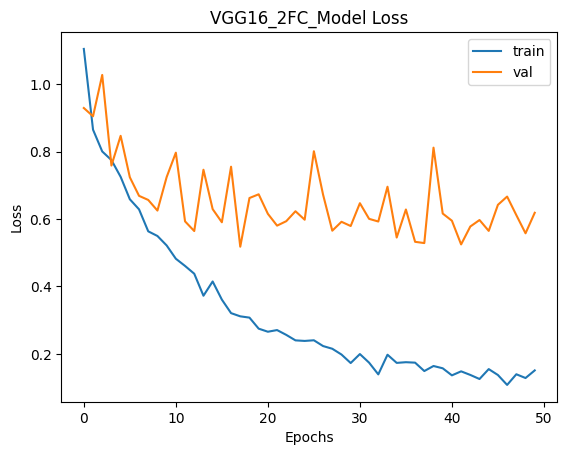

In [ ]:
loss = vgg16FC2_history.history['loss']
val_loss = vgg16FC2_history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('VGG16_2FC_Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16FC2_train_vs_val_loss.png")
plt.show()

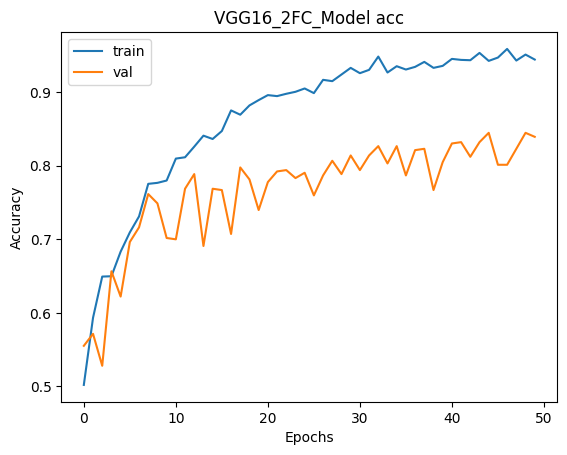

In [ ]:
accuracy = vgg16FC2_history.history['accuracy']
val_accuracy = vgg16FC2_history.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('VGG16_2FC_Model acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16FC2_train_vs_val_acc.png")
plt.show()

In [ ]:
class_names={0:"AD", 1:"MCI", 2:"NC"}

1/1 [==============================] - 0s 22ms/step


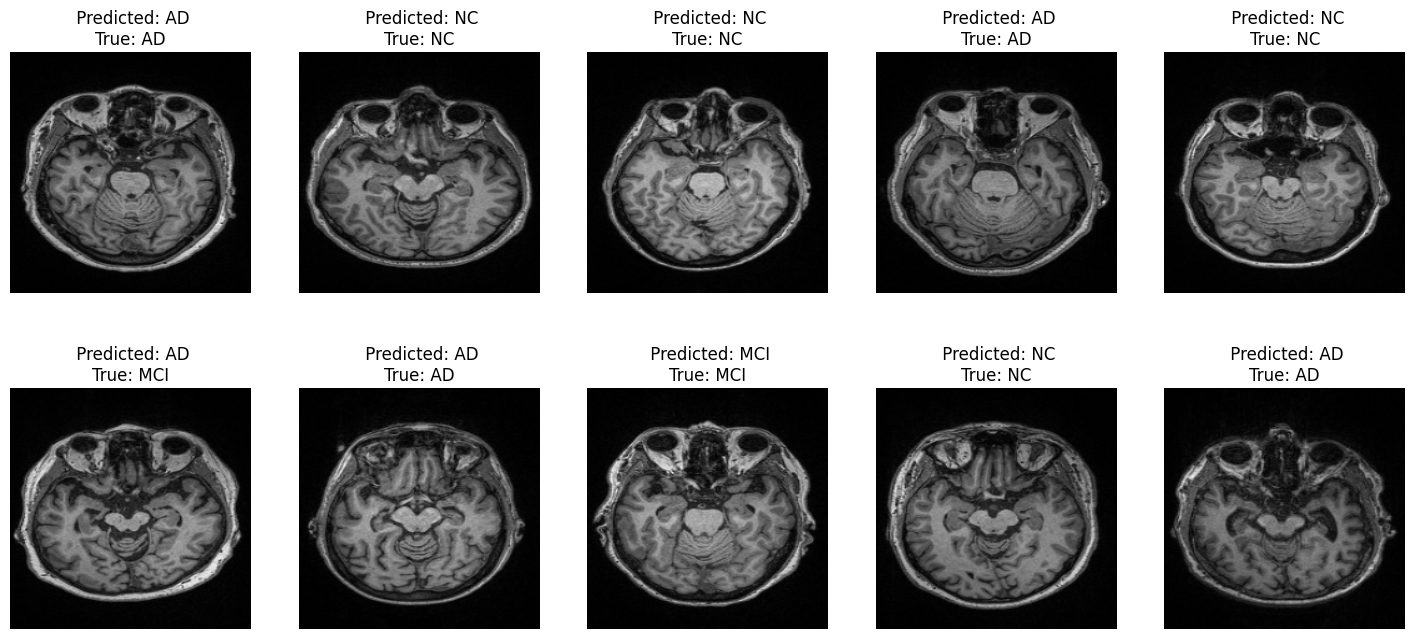

In [ ]:
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(18,8))
for images, labels in val_data.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i]/255)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        x = image.img_to_array(images[i])
        x = np.expand_dims(x, axis=0)
        p=np.argmax(model.predict(x))
        plt.title(f" Predicted: {class_names[p]}\nTrue: {val_data.class_names[labels[i]]}")
        plt.axis('off')
plt.savefig("vgg16FC2_true_vs_predict.png")

In [ ]:
import itertools
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Predicted')

Found 2768 files belonging to 3 classes.
Using 553 files for validation.
1/1 [==============================] - 0s 26ms/step


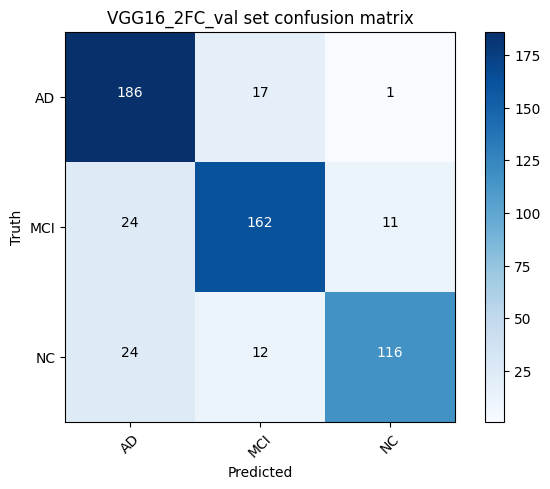

In [ ]:
val=base_dir+ 'train/'

vgg16FC2_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
    )
v_predictions = np.array([])
v_labels =  np.array([])
for x, y in vgg16FC2_val_data:
    v_predictions = np.concatenate([v_predictions, np.argmax(model.predict(x), axis = -1)])
    v_labels = np.concatenate([v_labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=v_labels, predictions=v_predictions).numpy()
confusion_mtx = confusion_matrix(v_labels, v_predictions)

plot_confusion_matrix(confusion_mtx, classes =  ['AD', 'MCI', 'NC'], title = 'VGG16_2FC_val set confusion matrix')
plt.savefig("vgg16FC2_val set confusion matrix.png")

In [ ]:
report = classification_report(v_labels, v_predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.79      0.91      0.85       204
         1.0       0.85      0.82      0.84       197
         2.0       0.91      0.76      0.83       152

    accuracy                           0.84       553
   macro avg       0.85      0.83      0.84       553
weighted avg       0.84      0.84      0.84       553



In [ ]:
model.save("./FYP2_vgg16FC2.h5")

# **VGG16+3FC**

In [ ]:
from tensorflow.keras.applications import VGG16

# Model Initialization
base_model = VGG16(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False


In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
# Define the model architecture
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D(name="GloPool")(x)
x = layers.Dense (256, activation = 'relu')(x)
x = layers.Dense (128, activation = 'relu')(x)
x = layers.Dense (64, activation = 'relu')(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 GloPool (GlobalAveragePooli  (None, 512)              0   

In [ ]:
len(model.trainable_variables)

8

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(10e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
import time
# get the start time
st=time.time()

initial_epochs = 50
vgg16FC3_history=model.fit (train_data,
                    validation_data=val_data,
                    epochs= initial_epochs,
                   verbose=1
                  )

# get the end time
et= time.time()

# get the execution time
res = et - st
final_res = res/60
print('Execution time:', final_res , 'minutes')

Epoch 1/50
139/139 [==============================] - 16s 101ms/step - loss: 1.0430 - accuracy: 0.4840 - val_loss: 1.0422 - val_accuracy: 0.4991
Epoch 2/50
139/139 [==============================] - 13s 90ms/step - loss: 0.9245 - accuracy: 0.5454 - val_loss: 0.9098 - val_accuracy: 0.5624
Epoch 3/50
139/139 [==============================] - 13s 89ms/step - loss: 0.8266 - accuracy: 0.6126 - val_loss: 1.0753 - val_accuracy: 0.5118
Epoch 4/50
139/139 [==============================] - 13s 89ms/step - loss: 0.7695 - accuracy: 0.6497 - val_loss: 0.7880 - val_accuracy: 0.6528
Epoch 5/50
139/139 [==============================] - 13s 89ms/step - loss: 0.7353 - accuracy: 0.6677 - val_loss: 0.7363 - val_accuracy: 0.6763
Epoch 6/50
139/139 [==============================] - 13s 89ms/step - loss: 0.7119 - accuracy: 0.6835 - val_loss: 0.6852 - val_accuracy: 0.7125
Epoch 7/50
139/139 [==============================] - 13s 89ms/step - loss: 0.6705 - accuracy: 0.6957 - val_loss: 0.7784 - val_accuracy

In [ ]:
model.evaluate(train_data)

139/139 [==============================] - 10s 67ms/step - loss: 0.1532 - accuracy: 0.9454


[0.15323257446289062, 0.945372462272644]

In [ ]:
model.evaluate(val_data)

35/35 [==============================] - 3s 68ms/step - loss: 0.5023 - accuracy: 0.8228


[0.5022852420806885, 0.8227847814559937]

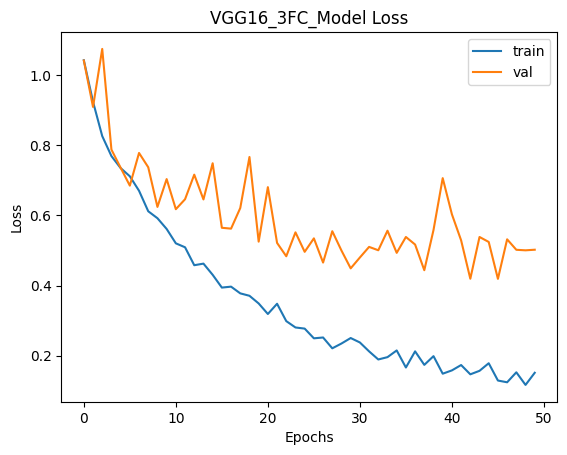

In [ ]:
loss = vgg16FC3_history.history['loss']
val_loss = vgg16FC3_history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('VGG16_3FC_Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16FC3_train_vs_val_loss.png")
plt.show()

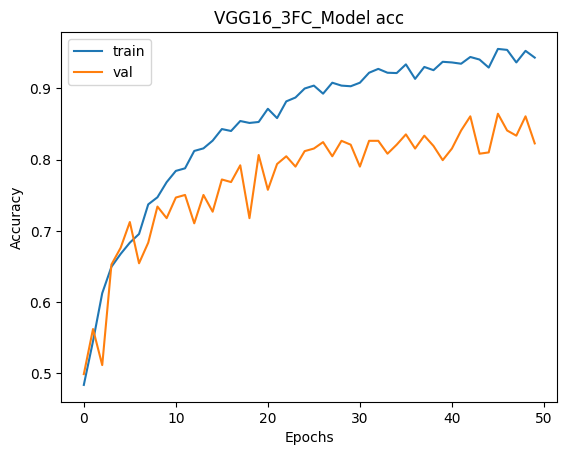

In [ ]:
accuracy = vgg16FC3_history.history['accuracy']
val_accuracy = vgg16FC3_history.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('VGG16_3FC_Model acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16FC3_train_vs_val_acc.png")
plt.show()

In [ ]:
class_names={0:"AD", 1:"MCI", 2:"NC"}

1/1 [==============================] - 0s 19ms/step


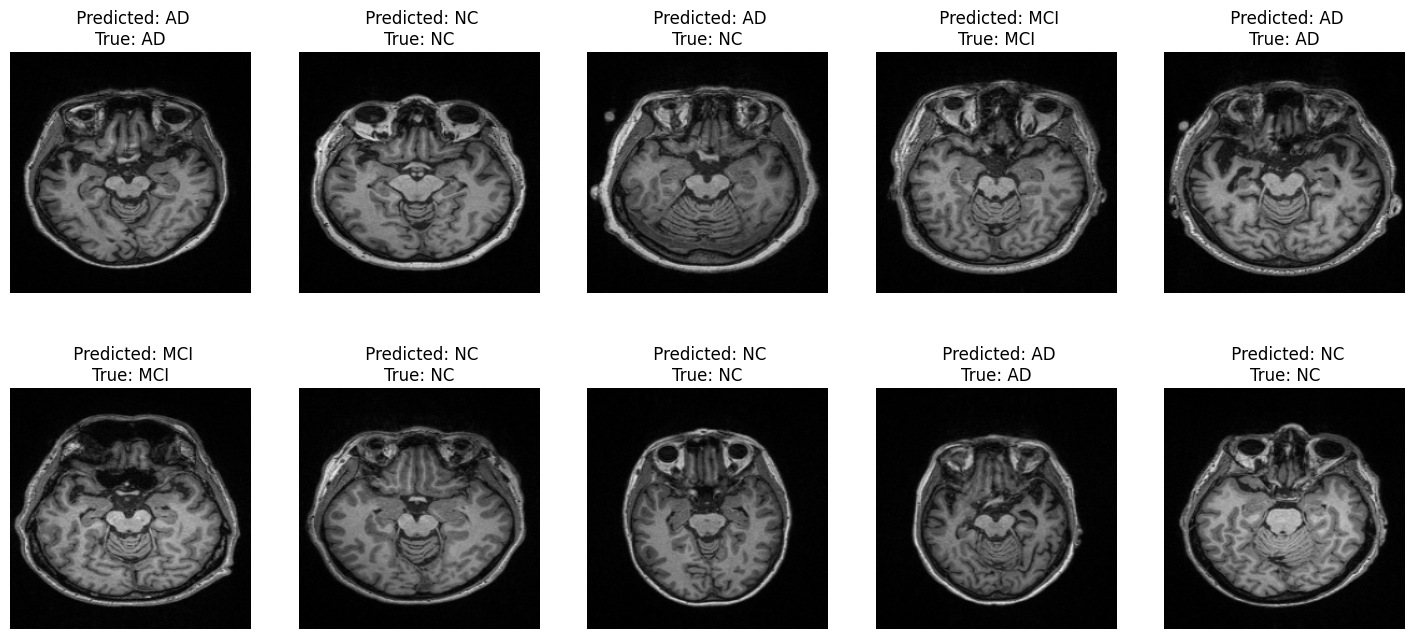

In [ ]:
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(18,8))
for images, labels in val_data.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i]/255)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        x = image.img_to_array(images[i])
        x = np.expand_dims(x, axis=0)
        p=np.argmax(model.predict(x))
        plt.title(f" Predicted: {class_names[p]}\nTrue: {val_data.class_names[labels[i]]}")
        plt.axis('off')
plt.savefig("vgg16FC3_true_vs_predict.png")

In [ ]:
import itertools
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Predicted')

Found 2768 files belonging to 3 classes.
Using 553 files for validation.
1/1 [==============================] - 0s 25ms/step


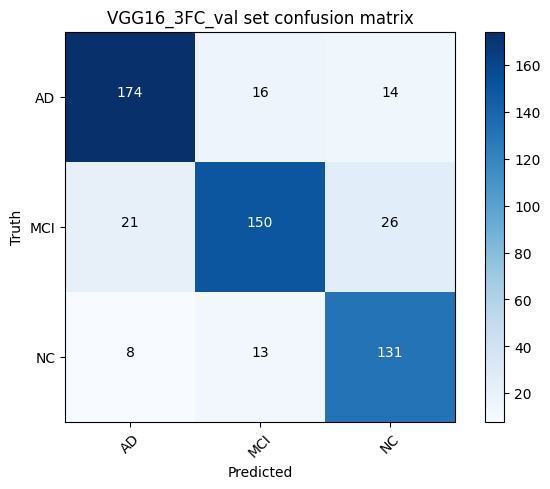

In [ ]:
val=base_dir+ 'train/'

vgg16FC3_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
    )
v_predictions = np.array([])
v_labels =  np.array([])
for x, y in vgg16FC3_val_data:
    v_predictions = np.concatenate([v_predictions, np.argmax(model.predict(x), axis = -1)])
    v_labels = np.concatenate([v_labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=v_labels, predictions=v_predictions).numpy()
confusion_mtx = confusion_matrix(v_labels, v_predictions)

plot_confusion_matrix(confusion_mtx, classes =  ['AD', 'MCI', 'NC'], title = 'VGG16_3FC_val set confusion matrix')
plt.savefig("vgg16FC3_val set confusion matrix.png")

In [ ]:
report = classification_report(v_labels, v_predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86       204
         1.0       0.84      0.76      0.80       197
         2.0       0.77      0.86      0.81       152

    accuracy                           0.82       553
   macro avg       0.82      0.83      0.82       553
weighted avg       0.83      0.82      0.82       553



In [ ]:
model.save("./FYP2_vgg16FC3.h5")

# **VGG16+1FC+dropout0.2**

In [ ]:
from tensorflow.keras.applications import VGG16

# Model Initialization
base_model = VGG16(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False


In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
# Define the model architecture
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D(name="GloPool")(x)
x = layers.Dense (256, activation = 'relu')(x)
x= layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_3 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 GloPool (GlobalAveragePooli  (None, 512)              0   

In [ ]:
len(model.trainable_variables)

4

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(10e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
import time
# get the start time
st=time.time()

initial_epochs = 50
vgg16FC1D2_history=model.fit (train_data,
                    validation_data=val_data,
                    epochs= initial_epochs,
                   verbose=1
                  )

# get the end time
et= time.time()

# get the execution time
res = et - st
final_res = res/60
print('Execution time:', final_res , 'minutes')

Epoch 1/50
139/139 [==============================] - 16s 97ms/step - loss: 1.4970 - accuracy: 0.4605 - val_loss: 0.8727 - val_accuracy: 0.6148
Epoch 2/50
139/139 [==============================] - 14s 98ms/step - loss: 0.9351 - accuracy: 0.5508 - val_loss: 0.8191 - val_accuracy: 0.6257
Epoch 3/50
139/139 [==============================] - 16s 113ms/step - loss: 0.8618 - accuracy: 0.6045 - val_loss: 0.7931 - val_accuracy: 0.6401
Epoch 4/50
139/139 [==============================] - 16s 106ms/step - loss: 0.7924 - accuracy: 0.6433 - val_loss: 0.8078 - val_accuracy: 0.6474
Epoch 5/50
139/139 [==============================] - 16s 111ms/step - loss: 0.7653 - accuracy: 0.6578 - val_loss: 0.7354 - val_accuracy: 0.6637
Epoch 6/50
139/139 [==============================] - 14s 100ms/step - loss: 0.7306 - accuracy: 0.6659 - val_loss: 0.7198 - val_accuracy: 0.6564
Epoch 7/50
139/139 [==============================] - 14s 97ms/step - loss: 0.6953 - accuracy: 0.6903 - val_loss: 0.6968 - val_accur

In [ ]:
model.evaluate(train_data)

139/139 [==============================] - 10s 66ms/step - loss: 0.1329 - accuracy: 0.9503


[0.13294626772403717, 0.95033860206604]

In [ ]:
model.evaluate(val_data)

35/35 [==============================] - 3s 67ms/step - loss: 0.4654 - accuracy: 0.8463


[0.46537861227989197, 0.8462929725646973]

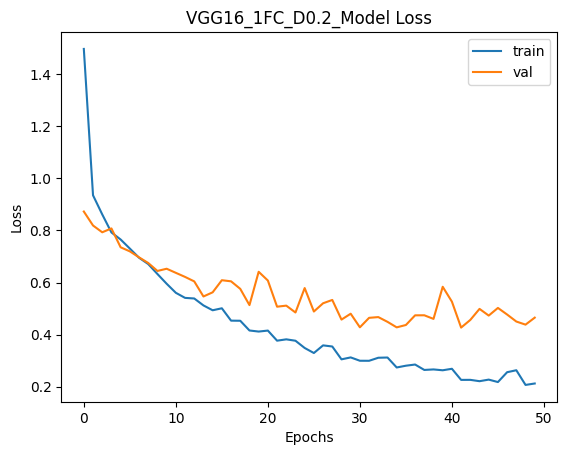

In [ ]:
loss = vgg16FC1D2_history.history['loss']
val_loss = vgg16FC1D2_history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('VGG16_1FC_D0.2_Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16FC1D2_train_vs_val_loss.png")
plt.show()

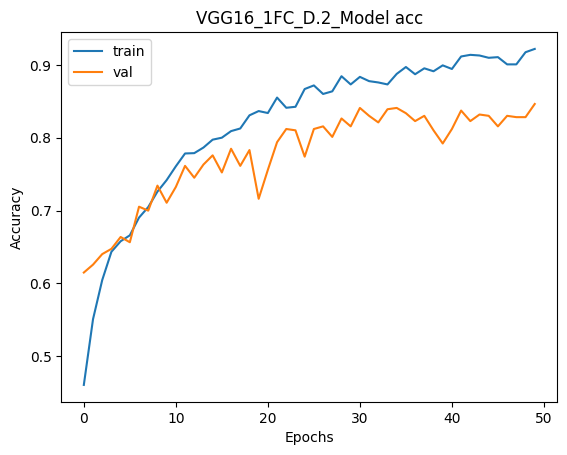

In [ ]:
accuracy = vgg16FC1D2_history.history['accuracy']
val_accuracy = vgg16FC1D2_history.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('VGG16_1FC_D0.2_Model acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16FC1D2_train_vs_val_acc.png")
plt.show()

In [ ]:
class_names={0:"AD", 1:"MCI", 2:"NC"}

1/1 [==============================] - 0s 19ms/step


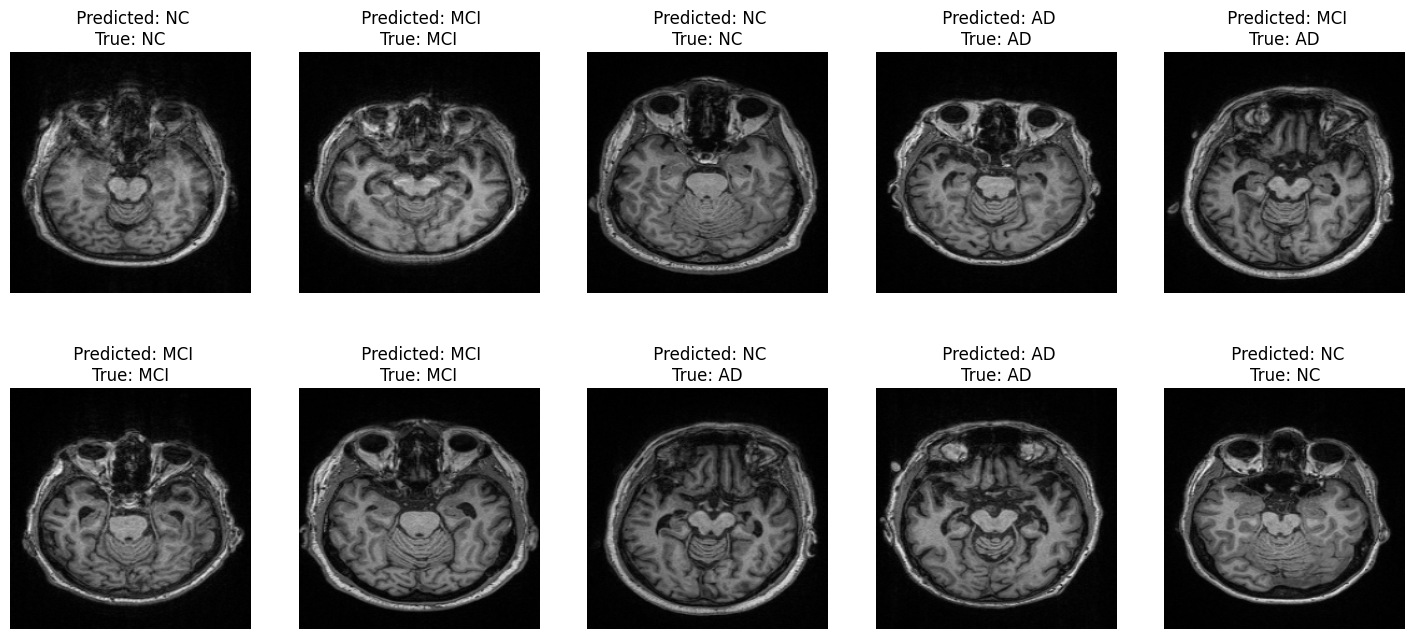

In [ ]:
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(18,8))
for images, labels in val_data.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i]/255)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        x = image.img_to_array(images[i])
        x = np.expand_dims(x, axis=0)
        p=np.argmax(model.predict(x))
        plt.title(f" Predicted: {class_names[p]}\nTrue: {val_data.class_names[labels[i]]}")
        plt.axis('off')
plt.savefig("vgg16FC1D2_true_vs_predict.png")

In [ ]:
import itertools
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Predicted')

Found 2768 files belonging to 3 classes.
Using 553 files for validation.
1/1 [==============================] - 0s 22ms/step


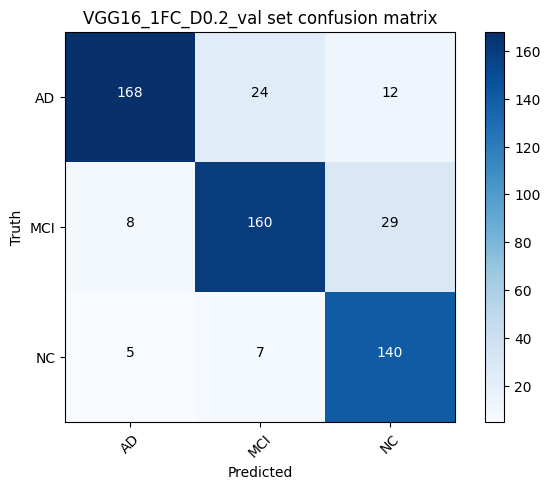

In [ ]:
val=base_dir+ 'train/'

vgg16FC1D2_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
    )
v_predictions = np.array([])
v_labels =  np.array([])
for x, y in vgg16FC1D2_val_data:
    v_predictions = np.concatenate([v_predictions, np.argmax(model.predict(x), axis = -1)])
    v_labels = np.concatenate([v_labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=v_labels, predictions=v_predictions).numpy()
confusion_mtx = confusion_matrix(v_labels, v_predictions)

plot_confusion_matrix(confusion_mtx, classes =  ['AD', 'MCI', 'NC'], title = 'VGG16_1FC_D0.2_val set confusion matrix')
plt.savefig("vgg16FC1D2_val set confusion matrix.png")

In [ ]:
report = classification_report(v_labels, v_predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87       204
         1.0       0.84      0.81      0.82       197
         2.0       0.77      0.92      0.84       152

    accuracy                           0.85       553
   macro avg       0.85      0.85      0.85       553
weighted avg       0.85      0.85      0.85       553



In [ ]:
model.save("./FYP2_vgg16FC1D2.h5")

# **VGG16+1FC+dropout0.3**

In [ ]:
from tensorflow.keras.applications import VGG16

# Model Initialization
base_model = VGG16(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False


In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
# Define the model architecture
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D(name="GloPool")(x)
x = layers.Dense (256, activation = 'relu')(x)
x= layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 GloPool (GlobalAveragePooli  (None, 512)              0   

In [ ]:
len(model.trainable_variables)

4

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(10e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
import time
# get the start time
st=time.time()

initial_epochs = 50
vgg16FC1D3_history=model.fit (train_data,
                    validation_data=val_data,
                    epochs= initial_epochs,
                   verbose=1
                  )

# get the end time
et= time.time()

# get the execution time
res = et - st
final_res = res/60
print('Execution time:', final_res , 'minutes')

Epoch 1/50
139/139 [==============================] - 14s 90ms/step - loss: 1.5568 - accuracy: 0.4637 - val_loss: 0.8871 - val_accuracy: 0.5805
Epoch 2/50
139/139 [==============================] - 13s 89ms/step - loss: 0.9214 - accuracy: 0.5580 - val_loss: 0.8238 - val_accuracy: 0.6239
Epoch 3/50
139/139 [==============================] - 13s 89ms/step - loss: 0.8659 - accuracy: 0.5896 - val_loss: 0.7910 - val_accuracy: 0.6510
Epoch 4/50
139/139 [==============================] - 13s 88ms/step - loss: 0.8252 - accuracy: 0.6167 - val_loss: 0.7771 - val_accuracy: 0.6311
Epoch 5/50
139/139 [==============================] - 13s 87ms/step - loss: 0.8041 - accuracy: 0.6194 - val_loss: 0.7359 - val_accuracy: 0.6835
Epoch 6/50
139/139 [==============================] - 15s 107ms/step - loss: 0.7751 - accuracy: 0.6528 - val_loss: 0.7403 - val_accuracy: 0.6817
Epoch 7/50
139/139 [==============================] - 13s 90ms/step - loss: 0.7258 - accuracy: 0.6722 - val_loss: 0.7274 - val_accuracy

In [ ]:
model.evaluate(train_data)

139/139 [==============================] - 10s 67ms/step - loss: 0.1670 - accuracy: 0.9368


[0.16700777411460876, 0.9367945790290833]

In [ ]:
model.evaluate(val_data)

35/35 [==============================] - 3s 66ms/step - loss: 0.4574 - accuracy: 0.8083


[0.4573914408683777, 0.8083182573318481]

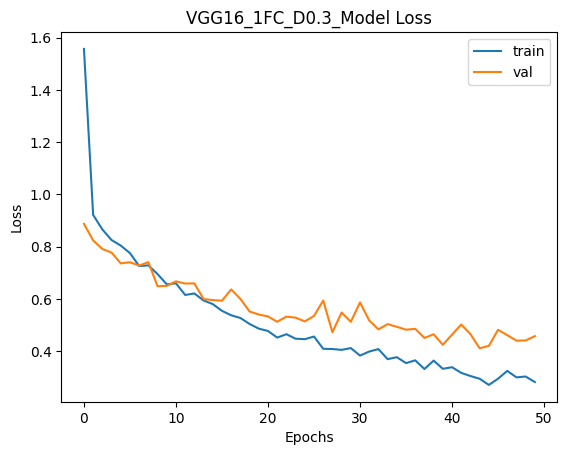

In [ ]:
loss = vgg16FC1D3_history.history['loss']
val_loss = vgg16FC1D3_history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('VGG16_1FC_D0.3_Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16FC1D3_train_vs_val_loss.png")
plt.show()

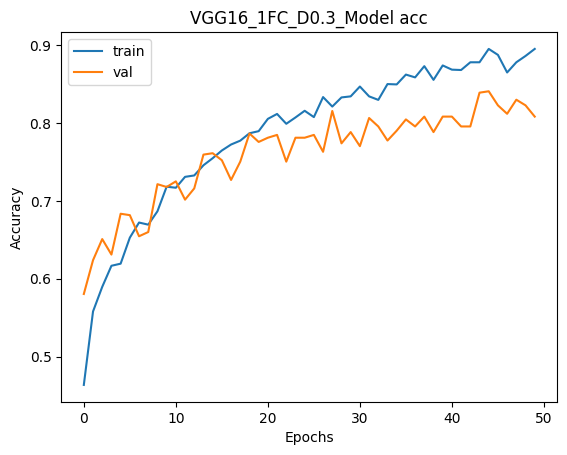

In [ ]:
accuracy = vgg16FC1D3_history.history['accuracy']
val_accuracy = vgg16FC1D3_history.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('VGG16_1FC_D0.3_Model acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16FC1D3_train_vs_val_acc.png")
plt.show()

In [ ]:
class_names={0:"AD", 1:"MCI", 2:"NC"}

1/1 [==============================] - 0s 21ms/step


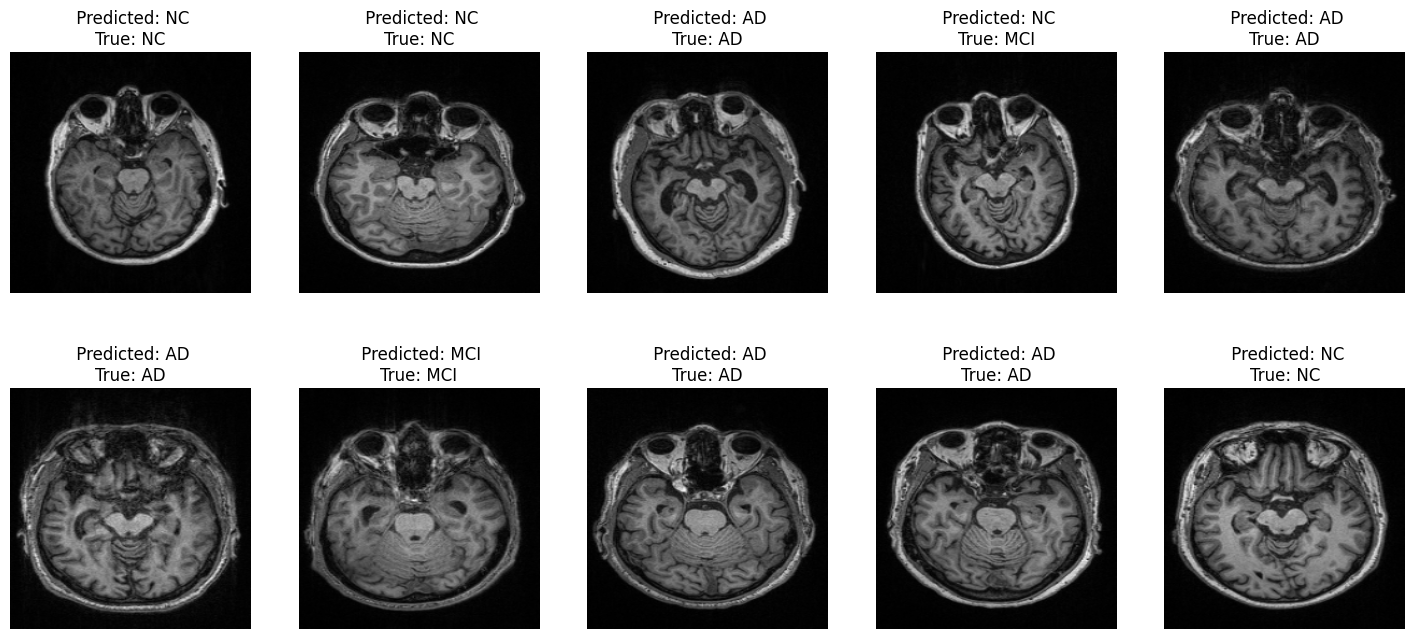

In [ ]:
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(18,8))
for images, labels in val_data.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i]/255)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        x = image.img_to_array(images[i])
        x = np.expand_dims(x, axis=0)
        p=np.argmax(model.predict(x))
        plt.title(f" Predicted: {class_names[p]}\nTrue: {val_data.class_names[labels[i]]}")
        plt.axis('off')
plt.savefig("vgg16FC1D3_true_vs_predict.png")

In [ ]:
import itertools
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Predicted')

Found 2768 files belonging to 3 classes.
Using 553 files for validation.
1/1 [==============================] - 0s 24ms/step


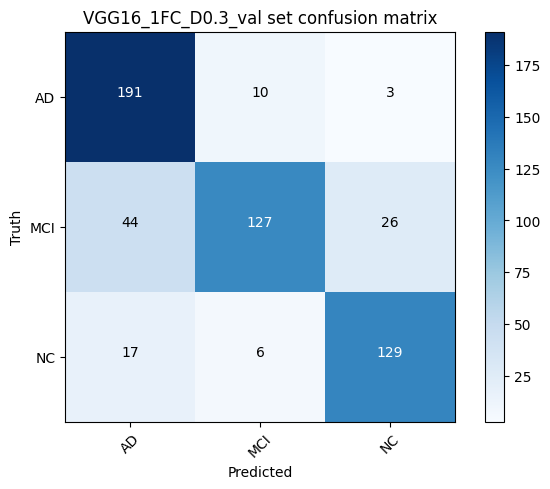

In [ ]:
val=base_dir+ 'train/'

vgg16FC1D3_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
    )
v_predictions = np.array([])
v_labels =  np.array([])
for x, y in vgg16FC1D3_val_data:
    v_predictions = np.concatenate([v_predictions, np.argmax(model.predict(x), axis = -1)])
    v_labels = np.concatenate([v_labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=v_labels, predictions=v_predictions).numpy()
confusion_mtx = confusion_matrix(v_labels, v_predictions)

plot_confusion_matrix(confusion_mtx, classes =  ['AD', 'MCI', 'NC'], title = 'VGG16_1FC_D0.3_val set confusion matrix')
plt.savefig("vgg16FC1D3_val set confusion matrix.png")

In [ ]:
report = classification_report(v_labels, v_predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.76      0.94      0.84       204
         1.0       0.89      0.64      0.75       197
         2.0       0.82      0.85      0.83       152

    accuracy                           0.81       553
   macro avg       0.82      0.81      0.81       553
weighted avg       0.82      0.81      0.80       553



In [ ]:
model.save("./FYP2_vgg16FC1D3.h5")

# **VGG161FC+dropout0.5**

In [ ]:
from tensorflow.keras.applications import VGG16

# Model Initialization
base_model = VGG16(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False


In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
# Define the model architecture
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D(name="GloPool")(x)
x = layers.Dense (256, activation = 'relu')(x)
x= layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_6   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 GloPool (GlobalAveragePooli  (None, 512)              0   

In [ ]:
len(model.trainable_variables)

4

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(10e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
import time
# get the start time
st=time.time()

initial_epochs = 50
vgg16FC1D5_history=model.fit (train_data,
                    validation_data=val_data,
                    epochs= initial_epochs,
                   verbose=1
                  )

# get the end time
et= time.time()

# get the execution time
res = et - st
final_res = res/60
print('Execution time:', final_res , 'minutes')

Epoch 1/50
139/139 [==============================] - 14s 90ms/step - loss: 1.6785 - accuracy: 0.4284 - val_loss: 0.9698 - val_accuracy: 0.4828
Epoch 2/50
139/139 [==============================] - 13s 89ms/step - loss: 0.9765 - accuracy: 0.5034 - val_loss: 0.8822 - val_accuracy: 0.5931
Epoch 3/50
139/139 [==============================] - 13s 89ms/step - loss: 0.9416 - accuracy: 0.5287 - val_loss: 0.8725 - val_accuracy: 0.5750
Epoch 4/50
139/139 [==============================] - 13s 89ms/step - loss: 0.9065 - accuracy: 0.5634 - val_loss: 0.8287 - val_accuracy: 0.6094
Epoch 5/50
139/139 [==============================] - 13s 89ms/step - loss: 0.8703 - accuracy: 0.5833 - val_loss: 0.8240 - val_accuracy: 0.6058
Epoch 6/50
139/139 [==============================] - 13s 88ms/step - loss: 0.8552 - accuracy: 0.5770 - val_loss: 0.8087 - val_accuracy: 0.6076
Epoch 7/50
139/139 [==============================] - 12s 88ms/step - loss: 0.8499 - accuracy: 0.5833 - val_loss: 0.7846 - val_accuracy:

In [ ]:
model.evaluate(train_data)

139/139 [==============================] - 10s 67ms/step - loss: 0.2947 - accuracy: 0.8962


[0.2947435975074768, 0.8961625099182129]

In [ ]:
model.evaluate(val_data)

35/35 [==============================] - 3s 67ms/step - loss: 0.5110 - accuracy: 0.7993


[0.5110024809837341, 0.7992766499519348]

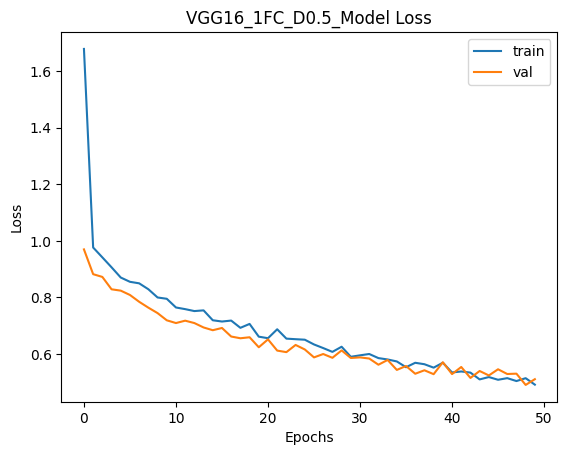

In [ ]:
loss = vgg16FC1D5_history.history['loss']
val_loss = vgg16FC1D5_history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.title('VGG16_1FC_D0.5_Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16FC1D5_train_vs_val_loss.png")
plt.show()

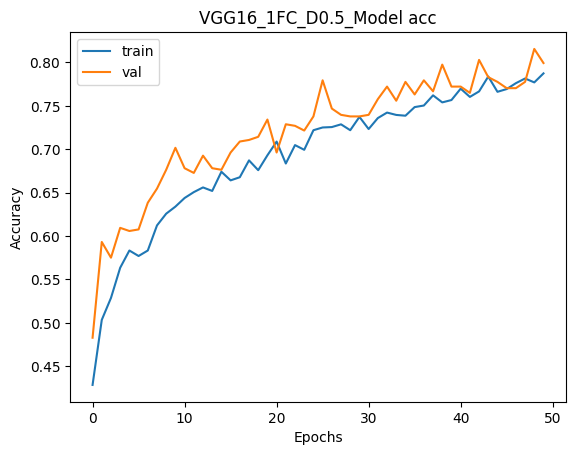

In [ ]:
accuracy = vgg16FC1D5_history.history['accuracy']
val_accuracy = vgg16FC1D5_history.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('VGG16_1FC_D0.5_Model acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.savefig("vgg16FC1D5_train_vs_val_acc.png")
plt.show()

In [ ]:
class_names={0:"AD", 1:"MCI", 2:"NC"}

1/1 [==============================] - 0s 20ms/step


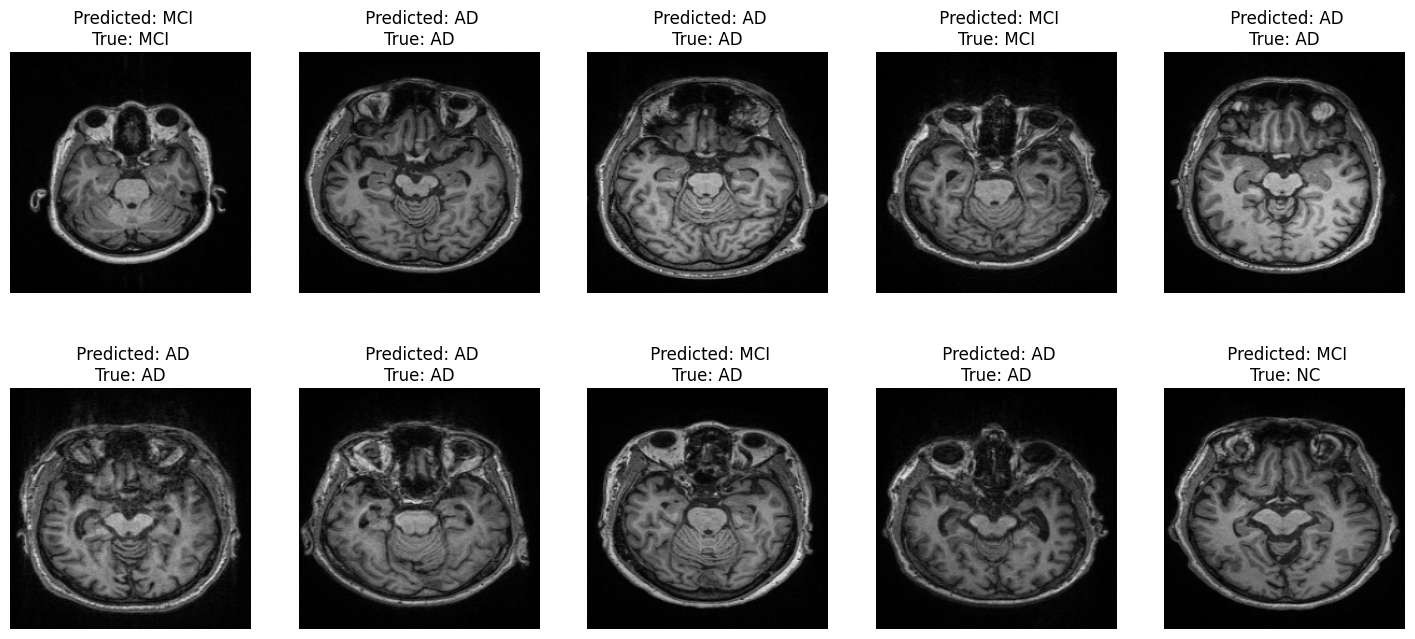

In [ ]:
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(18,8))
for images, labels in val_data.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i]/255)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        x = image.img_to_array(images[i])
        x = np.expand_dims(x, axis=0)
        p=np.argmax(model.predict(x))
        plt.title(f" Predicted: {class_names[p]}\nTrue: {val_data.class_names[labels[i]]}")
        plt.axis('off')
plt.savefig("vgg16FC1D5_true_vs_predict.png")

In [ ]:
import itertools
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Predicted')

Found 2768 files belonging to 3 classes.
Using 553 files for validation.
1/1 [==============================] - 0s 24ms/step


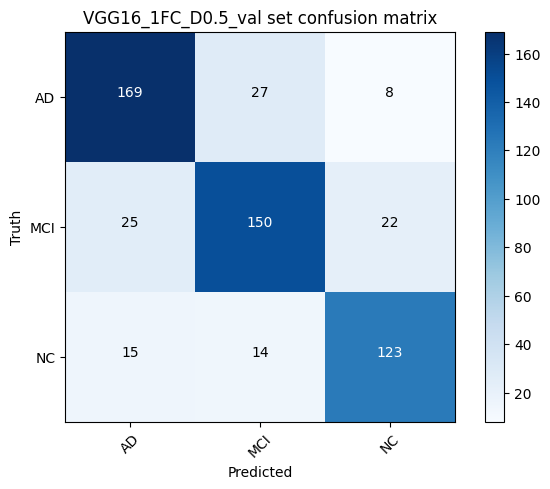

In [ ]:
val=base_dir+ 'train/'

vgg16FC1D5_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
    )
v_predictions = np.array([])
v_labels =  np.array([])
for x, y in vgg16FC1D5_val_data:
    v_predictions = np.concatenate([v_predictions, np.argmax(model.predict(x), axis = -1)])
    v_labels = np.concatenate([v_labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=v_labels, predictions=v_predictions).numpy()
confusion_mtx = confusion_matrix(v_labels, v_predictions)

plot_confusion_matrix(confusion_mtx, classes =  ['AD', 'MCI', 'NC'], title = 'VGG16_1FC_D0.5_val set confusion matrix')
plt.savefig("vgg16FC1D5_val set confusion matrix.png")

In [ ]:
report = classification_report(v_labels, v_predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       204
         1.0       0.79      0.76      0.77       197
         2.0       0.80      0.81      0.81       152

    accuracy                           0.80       553
   macro avg       0.80      0.80      0.80       553
weighted avg       0.80      0.80      0.80       553



In [ ]:
model.save("./FYP2_vgg16FC1D5.h5")

# **VGG16 with fine tune**

In [ ]:
print ("base model layers:",len(base_model.layers))

base_model.trainable = True

#fine tune from this layers onwards
fine_tune_at = 15

#Freezing Layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable= False

base model layers: 19


In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_8   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_8 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 GloPool (GlobalAveragePooli  (None, 512)              0   

In [ ]:
len(model.trainable_variables)

10

In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_7 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(1e-5),
                          loss="sparse_categorical_crossentropy",
                          metrics=["accuracy"])

In [ ]:
import time
# get the start time
st=time.time()

fine_tune_epochs=20
total_epochs= initial_epochs + fine_tune_epochs

vgg16ft_history=model.fit (train_data,
                    validation_data=val_data,
                    epochs= total_epochs,
                    initial_epoch= vgg16FC1D5_history.epoch[-1],
                   verbose=1
                  )

# get the end time
et= time.time()

# get the execution time
res = et - st
final_res = res/60
print('Execution time:', final_res , 'minutes')

Epoch 50/70
139/139 [==============================] - 19s 106ms/step - loss: 0.5003 - accuracy: 0.7806 - val_loss: 0.5170 - val_accuracy: 0.7920
Epoch 51/70
139/139 [==============================] - 15s 104ms/step - loss: 0.4311 - accuracy: 0.8217 - val_loss: 0.5134 - val_accuracy: 0.8029
Epoch 52/70
139/139 [==============================] - 14s 102ms/step - loss: 0.4220 - accuracy: 0.8221 - val_loss: 0.4404 - val_accuracy: 0.8119
Epoch 53/70
139/139 [==============================] - 14s 101ms/step - loss: 0.3687 - accuracy: 0.8488 - val_loss: 0.3875 - val_accuracy: 0.8499
Epoch 54/70
139/139 [==============================] - 15s 103ms/step - loss: 0.3607 - accuracy: 0.8447 - val_loss: 0.4671 - val_accuracy: 0.8119
Epoch 55/70
139/139 [==============================] - 15s 103ms/step - loss: 0.3395 - accuracy: 0.8686 - val_loss: 0.4480 - val_accuracy: 0.8373
Epoch 56/70
139/139 [==============================] - 14s 101ms/step - loss: 0.3355 - accuracy: 0.8650 - val_loss: 0.3541 -

In [ ]:
model.evaluate(train_data)

139/139 [==============================] - 10s 68ms/step - loss: 0.0598 - accuracy: 0.9770


[0.05982624739408493, 0.97697514295578]

In [ ]:
model.evaluate(val_data)

35/35 [==============================] - 3s 69ms/step - loss: 0.2941 - accuracy: 0.8969


[0.2941420078277588, 0.8969258666038513]

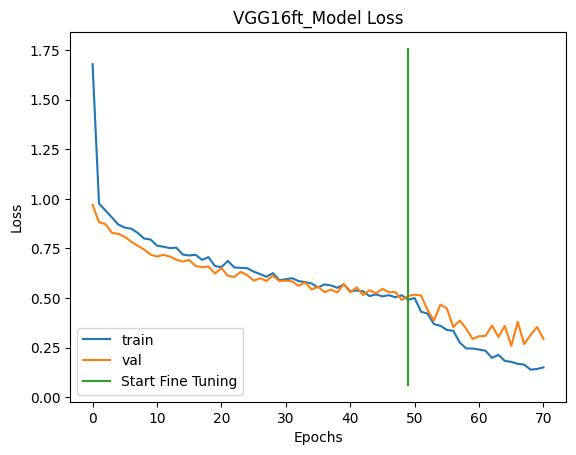

In [ ]:
loss += vgg16ft_history.history['loss']
val_loss += vgg16ft_history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.title('VGG16ft_Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val','Start Fine Tuning'])
plt.savefig("vgg16ft_train_vs_val_loss.png")
plt.show()

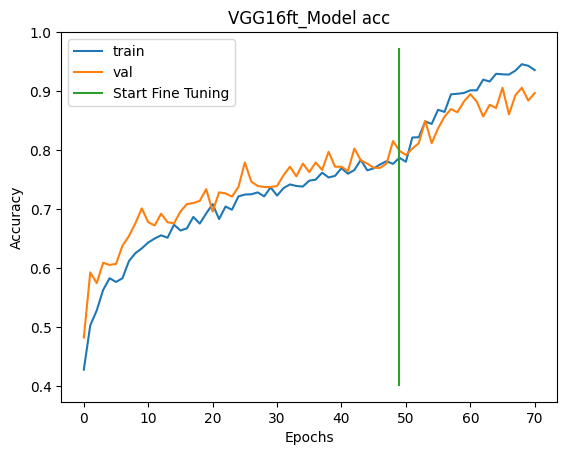

In [ ]:
accuracy += vgg16ft_history.history['accuracy']
val_accuracy += vgg16ft_history.history['val_accuracy']

plt.plot(accuracy)
plt.plot(val_accuracy)
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.title('VGG16ft_Model acc')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val','Start Fine Tuning'])
plt.savefig("vgg16ft_train_vs_val_acc.png")
plt.show()

In [ ]:
class_names={0:"AD", 1:"MCI", 2:"NC"}

1/1 [==============================] - 0s 22ms/step


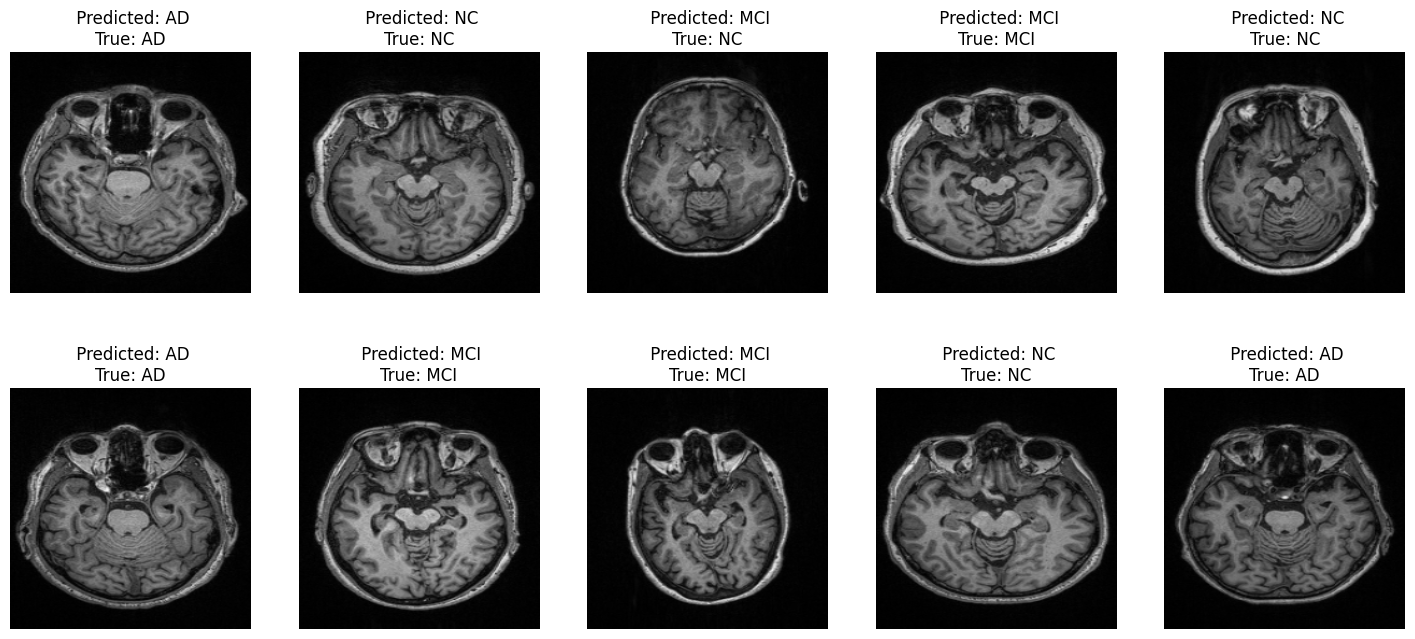

In [ ]:
from tensorflow.keras.preprocessing import image

plt.figure(figsize=(18,8))
for images, labels in val_data.take(1):
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(images[i]/255)
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        x = image.img_to_array(images[i])
        x = np.expand_dims(x, axis=0)
        p=np.argmax(model.predict(x))
        plt.title(f" Predicted: {class_names[p]}\nTrue: {val_data.class_names[labels[i]]}")
        plt.axis('off')
plt.savefig("vgg16ft_true_vs_predict.png")

In [ ]:
import itertools
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Truth')
    plt.xlabel('Predicted')

Found 2768 files belonging to 3 classes.
Using 553 files for validation.
1/1 [==============================] - 0s 22ms/step


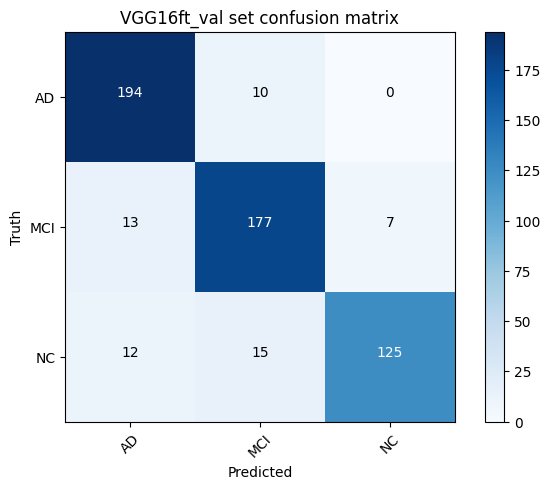

In [ ]:
val=base_dir+ 'train/'

vgg16ft_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=16,
    subset='validation',
    seed=1000
    )
v_predictions = np.array([])
v_labels =  np.array([])
for x, y in vgg16ft_val_data:
    v_predictions = np.concatenate([v_predictions, np.argmax(model.predict(x), axis = -1)])
    v_labels = np.concatenate([v_labels, np.argmax(y.numpy(), axis=-1)])

tf.math.confusion_matrix(labels=v_labels, predictions=v_predictions).numpy()
confusion_mtx = confusion_matrix(v_labels, v_predictions)

plot_confusion_matrix(confusion_mtx, classes =  ['AD', 'MCI', 'NC'], title = 'VGG16ft_val set confusion matrix')
plt.savefig("vgg16ft_val set confusion matrix.png")

In [ ]:
report = classification_report(v_labels, v_predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       204
         1.0       0.88      0.90      0.89       197
         2.0       0.95      0.82      0.88       152

    accuracy                           0.90       553
   macro avg       0.90      0.89      0.89       553
weighted avg       0.90      0.90      0.90       553



In [ ]:
model.save("./FYP2_vgg16ft.h5")

# **TESTING**

In [ ]:
model=load_model ('/content/drive/MyDrive/colab/OASIS/FYP2_vgg16ft.h5')

1/1 [==============================] - 0s 165ms/step


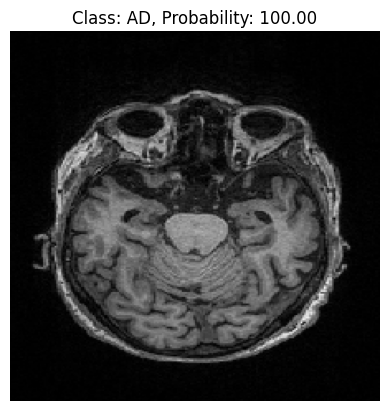

In [ ]:
# Test Case 1: AD

path= '/content/drive/MyDrive/colab/OASIS/test/AD/sub-OAS30190_ses-d0082_run-01_z108.png'
img = image.load_img (path, target_size= (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

p=model.predict(x)
probability= np.max(p*100)
plt.imshow(img)
plt.title("Class: {}, Probability: {:.2f}".format(class_names[np.argmax(p)],probability))
plt.axis ('off')
plt.savefig('VGG16FT # Test Case 1: AD')

1/1 [==============================] - 0s 19ms/step


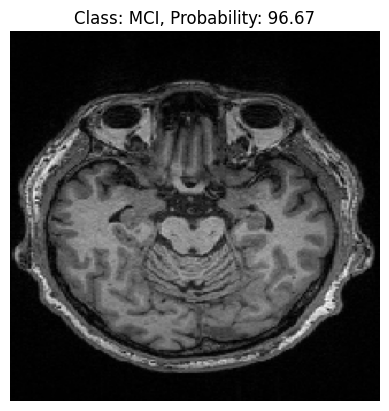

In [ ]:
# Test Case 2: MCI

path= '/content/drive/MyDrive/colab/OASIS/test/MCI/sub-OAS30313_ses-d0048_z110.png'
img = image.load_img (path, target_size= (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

p=model.predict(x)
probability= np.max(p*100)
plt.imshow(img)
plt.title("Class: {}, Probability: {:.2f}".format(class_names[np.argmax(p)],probability))
plt.axis ('off')
plt.savefig('VGG16FT # Test Case 2: MCI')

1/1 [==============================] - 0s 33ms/step


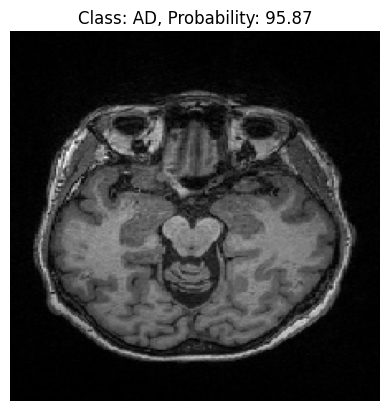

In [ ]:
# Test Case 3: NC

path= '/content/drive/MyDrive/colab/OASIS/test/NC/sub-OAS30052_ses-d0693_run-01_z114.png'
img = image.load_img (path, target_size= (224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

p=model.predict(x)
probability= np.max(p*100)
plt.imshow(img)
plt.title("Class: {}, Probability: {:.2f}".format(class_names[np.argmax(p)], probability ))
plt.axis ('off')
plt.savefig('VGG16FT # Test Case 3: NC')